In [1298]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM 
from tensorflow.keras.callbacks import EarlyStopping
from lab_utils import generate_sequences


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import math

In [1299]:
df = pd.read_csv('./results.csv', index_col=['Symbol'], parse_dates=True)
grouped = df.groupby(level='Symbol')
target_group= grouped.get_group("btc")
 
FEATURES_NAME_LIST=["Upper","Lower","EMA20",
                    "EMA10","EMA3","EMA5","EMA7","SMA10","SMA3",
                    "SMA5","SMA7","SMA20","MACD","SignalLine","RSI",
                    "OBV",
"Close"  ]
dataset=target_group[FEATURES_NAME_LIST]
TARGET_CLOSE="Close"
dataset['Close_P'] =dataset['Close']

dataset['Close'] = target_group[TARGET_CLOSE].shift(-1)
FEATURES_NAME_LIST.insert(0, "Close_P")
dataset=dataset[FEATURES_NAME_LIST]

dataset.dropna(how='any', inplace=True)
dataset.isna().sum()   
print(dataset['Close_P'],dataset['Close'])
dataset.isna().sum()   

Symbol
btc      123.100000
btc      123.880000
btc      120.501000
btc      122.580000
btc      122.900000
           ...     
btc    27024.765729
btc    26787.690396
btc    26798.126271
btc    26911.805273
btc    27227.793423
Name: Close_P, Length: 3650, dtype: float64 Symbol
btc      123.880000
btc      120.501000
btc      122.580000
btc      122.900000
btc      123.000000
           ...     
btc    26787.690396
btc    26798.126271
btc    26911.805273
btc    27227.793423
btc    27063.155557
Name: Close, Length: 3650, dtype: float64


/var/folders/z_/m_x5mlys3p7_27yygjsnmvm00000gn/T/ipykernel_71381/2306326717.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Close_P'] =dataset['Close']
/var/folders/z_/m_x5mlys3p7_27yygjsnmvm00000gn/T/ipykernel_71381/2306326717.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Close'] = target_group[TARGET_CLOSE].shift(-1)


Close_P       0
Upper         0
Lower         0
EMA20         0
EMA10         0
EMA3          0
EMA5          0
EMA7          0
SMA10         0
SMA3          0
SMA5          0
SMA7          0
SMA20         0
MACD          0
SignalLine    0
RSI           0
OBV           0
Close         0
dtype: int64

In [1300]:
# Normalize the data
scaler_X = MinMaxScaler(feature_range=(0,1))
scaler_y = MinMaxScaler(feature_range=(0,1))
scaled_X = scaler_X.fit_transform(dataset.iloc[:,:-1].values)  # all columns but the last one
scaled_y = scaler_y.fit_transform(dataset.iloc[:,-1].values.reshape(-1,1))  # the last column (Close)
scaled_data = np.concatenate((scaled_X, scaled_y), axis=1)


In [1301]:
#Create the LSTM data structure
def create_dataset(_dataset, look_back=1):
    X, Y = [], []
    for i in range(look_back, len(_dataset)):
        X.append(_dataset[i-look_back:i,:-1])  # all columns but the last one (Close)
        Y.append(_dataset[i,-1])  # the last column (Close)
    return np.array(X), np.array(Y)


In [1302]:
look_back = 3  # window size
X, y = create_dataset(scaled_data, look_back)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05 , shuffle=False)


In [1303]:

np.random.seed(1)
tf.random.set_seed(1)

# Define the LSTM model
model = Sequential([
    LSTM(64, return_sequences=True , input_shape=(X_train.shape[1], X_train.shape[2]),activation='tanh' , name="LSTM_1"),
    LSTM(64 ,return_sequences=False  , activation='tanh' ,  name="LSTM_2"),
    Dense(128, activation="tanh" ,  name="FULLY_CONNECTED_1"),
    Dense(64, activation="tanh" ,  name="FULLY_CONNECTED_2"),
    Dense(32, activation="tanh" ,  name="FULLY_CONNECTED_3"),
    Dense(1, name="OUTPUT")
],name="RNN_LSTM_TI")

model.summary()

Model: "RNN_LSTM_TI"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM_1 (LSTM)               (None, 3, 64)             20992     
                                                                 
 LSTM_2 (LSTM)               (None, 64)                33024     
                                                                 
 FULLY_CONNECTED_1 (Dense)   (None, 128)               8320      
                                                                 
 FULLY_CONNECTED_2 (Dense)   (None, 64)                8256      
                                                                 
 FULLY_CONNECTED_3 (Dense)   (None, 32)                2080      
                                                                 
 OUTPUT (Dense)              (None, 1)                 33        
                                                                 
Total params: 72,705
Trainable params: 72,705
Non-train

In [1304]:
model.compile(loss='mean_squared_error', optimizer='adam' )
callback = EarlyStopping(monitor="loss", patience=15, verbose=1, mode="auto")

model.fit(x=X_train, y=y_train, batch_size=256, epochs=1000 , callbacks=[callback])

Epoch 1/1000


2023-05-16 18:36:18.513407: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-16 18:36:19.034724: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-16 18:36:20.511555: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-16 18:36:22.502032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-16 18:36:23.888240: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 16s 539ms/step - loss: 0.0189
Epoch 2/1000
14/14 [==============================] - 2s 148ms/step - loss: 0.0022
Epoch 3/1000
14/14 [==============================] - 1s 84ms/step - loss: 8.2325e-04
Epoch 4/1000
14/14 [==============================] - 1s 61ms/step - loss: 5.1160e-04
Epoch 5/1000
14/14 [==============================] - 1s 97ms/step - loss: 4.2615e-04
Epoch 6/1000
14/14 [==============================] - 1s 96ms/step - loss: 4.0183e-04
Epoch 7/1000
14/14 [==============================] - 0s 34ms/step - loss: 3.9210e-04
Epoch 8/1000
14/14 [==============================] - 1s 45ms/step - loss: 3.6591e-04
Epoch 9/1000
14/14 [==============================] - 0s 34ms/step - loss: 3.5467e-04
Epoch 10/1000
14/14 [==============================] - 0s 19ms/step - loss: 3.6860e-04
Epoch 11/1000
14/14 [==============================] - 0s 22ms/step - loss: 3.5203e-04
Epoch 12/1000
14/14 [==============================] - 0s 21ms/step - 

In [1305]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invert predictions back to original scale
train_predict = scaler_y.inverse_transform(train_predict)
y_train = scaler_y.inverse_transform([y_train])
test_predict = scaler_y.inverse_transform(test_predict)


2023-05-16 18:37:09.009956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-16 18:37:09.214637: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-16 18:37:10.010726: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 1s 254ms/step


In [1306]:


# Calculate root mean squared error
train_score = math.sqrt(mean_squared_error(y_train[0], train_predict[:,0]))
print('Train Score: %.2f RMSE' % (train_score))
test_predict_set= test_predict[:,0][1:]
y_test=dataset["Close_P"].tail(len(test_predict)).values
test_score = math.sqrt(mean_squared_error(y_test[1:],test_predict[:,0][1:]))
print('Test Score: %.2f RMSE' % (test_score))



Train Score: 1065.56 RMSE
Test Score: 664.81 RMSE


/var/folders/z_/m_x5mlys3p7_27yygjsnmvm00000gn/T/ipykernel_71381/3448309881.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['Predictions'] =test_predict
/var/folders/z_/m_x5mlys3p7_27yygjsnmvm00000gn/T/ipykernel_71381/3448309881.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set.dropna(how='any', inplace=True)


                           Date         Close       Close_P   Predictions
Symbol                                                                   
btc     2023-04-28 08:00:00.000  29483.521705  29483.521705  28279.689453
btc     2023-04-29 08:00:00.000  29339.994998  29339.994998  28858.775391
btc     2023-04-30 08:00:00.000  29217.944047  29217.944047  29320.167969
btc     2023-05-01 08:00:00.000  29362.056214  29362.056214  29467.365234
btc     2023-05-02 08:00:00.000  28125.501156  28125.501156  29527.511719
btc     2023-05-03 08:00:00.000  28654.390133  28654.390133  29437.041016
btc     2023-05-04 08:00:00.000  28988.320996  28988.320996  28376.876953
btc     2023-05-05 08:00:00.000  28846.461459  28846.461459  28089.970703
btc     2023-05-06 08:00:00.000  29520.322269  29520.322269  28737.119141
btc     2023-05-07 08:00:00.000  28887.741046  28887.741046  28988.646484
btc     2023-05-08 08:00:00.000  28611.439198  28611.439198  29383.798828
btc     2023-05-09 08:00:00.000  27696

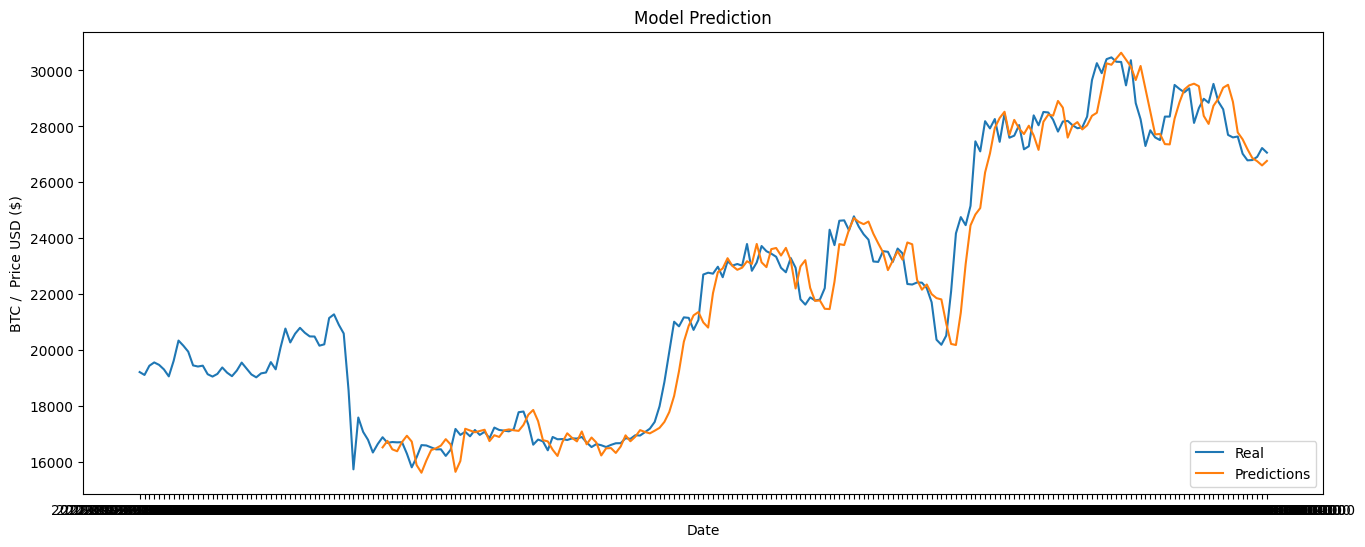

In [1308]:
chart_ori = target_group.loc[:, ["Date", "Close"]]
chart_ori["Close_P"]=target_group.loc[:,["Close"]]
chart_ori["Close"]=target_group.loc[:,TARGET_CLOSE]
chart_ori=chart_ori.tail(50+len(test_predict))
test_set = chart_ori.tail(len(test_predict))
test_set['Predictions'] =test_predict
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
test_set.dropna(how='any', inplace=True)

ax.plot(chart_ori['Date'],chart_ori['Close_P'])
ax.plot(test_set['Date'],test_set['Predictions'] )
ax.set(title='Model Prediction', xlabel='Date', ylabel='BTC /  Price USD ($)')
plt.legend(['Real', 'Predictions', 'Predictions'], loc='lower right')
plt.show()